### TP 3

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

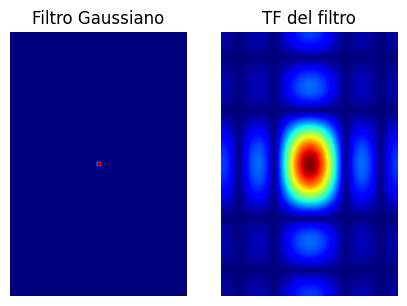

In [127]:
def create_gauss_filter(h, w, k_size, sigma):
    canvas = np.zeros((h, w))
    kernel = cv.getGaussianKernel(k_size, sigma)
    
    kernel = kernel @ kernel.T
    
    start_y = h // 2 - kernel.shape[0] // 2
    start_x = w // 2 - kernel.shape[1] // 2
    
    canvas[
        start_y : start_y + kernel.shape[0],
        start_x : start_x + kernel.shape[1],
    ] = kernel
    
    return canvas, np.fft.fft2(canvas)
    

gaussian_filter, filter_tf = create_gauss_filter(300, 200, k_size=5, sigma=5)

# Filtro con kernel= 5 y desviación estándar = 5

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Filtro Gaussiano")
plt.imshow(gaussian_filter, cmap="jet")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("TF del filtro")
plt.imshow(np.abs(np.fft.fftshift(filter_tf)), cmap="jet")
plt.show()

In [3]:
# Filtro en el dominio spectral
def filter_image_spectral(img, k_size, sigma):
    _, filter_tf = create_gauss_filter(img.shape[0],img.shape[1],k_size=k_size,sigma=sigma)
    img_fft = np.fft.fft2(img)
    filtered = img_fft * filter_tf
    return np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

In [4]:
# Filtro en el dominio espacial
def filter_spatial_domain(img, k_size, sigma):
    if k_size % 2 == 0:
        k_size += 1

    filter_spatial = cv.GaussianBlur(img, (k_size, k_size), sigmaX=sigma, sigmaY=sigma)
    return filter_spatial

In [5]:
# Filtrado convolucional
def filter_image_conv(img, k_size, sigma):
    kernel = cv.getGaussianKernel(k_size, sigma)
    kernel = kernel @ kernel.T
    return cv.filter2D(img, -1, kernel)

In [6]:
def plot_filtered_image(image, filter_func, combinations, col_row=(4,3)):
    num_images = len(combinations)
    cols, rows = col_row
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.ravel()

    for i, (k, s) in enumerate(combinations):
        filtered_image = filter_func(image, k, s)
        ax = axes[i]
        ax.imshow(filtered_image, cmap='gray')
        ax.set_title(f"k={k}, sigma={s}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
original_img = cv.imread('./TP3/images/coca_logo_1.png', cv.IMREAD_GRAYSCALE)
k_size = [5, 10, 20]
sigma = [1, 5, 10, 20]

combinations = [(k, s) for k in k_size for s in sigma]

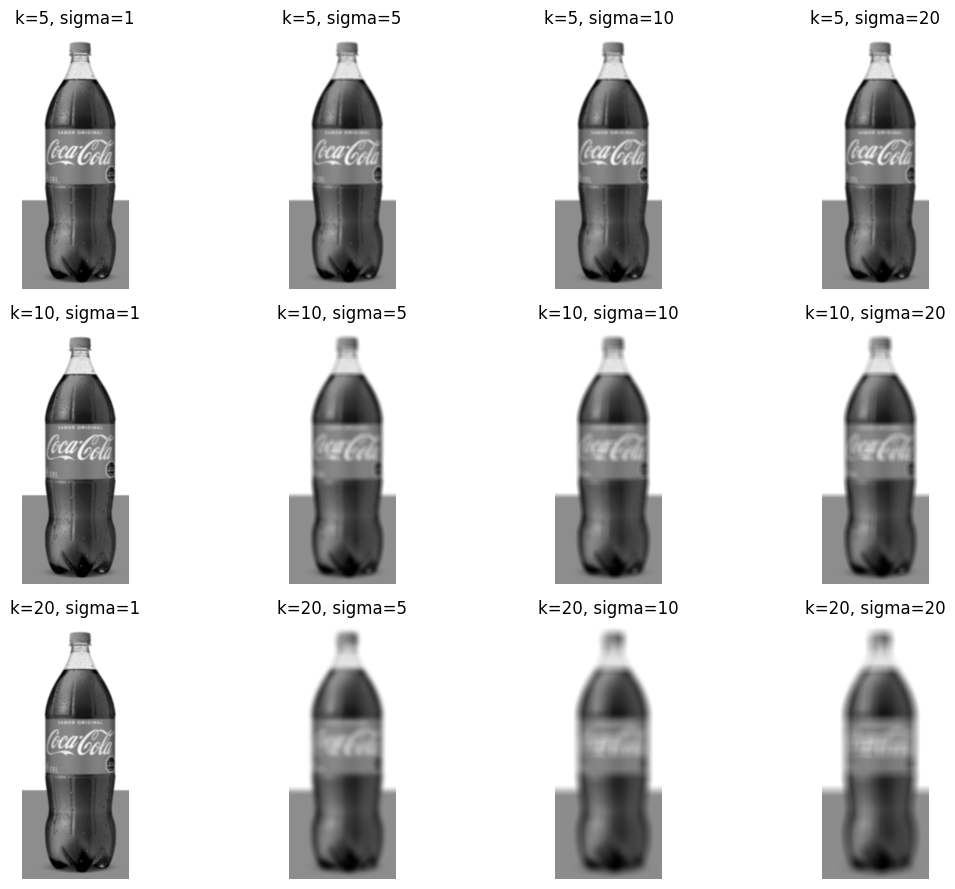

In [8]:
# Grafico espacial
plot_filtered_image(original_img, filter_spatial_domain, combinations)

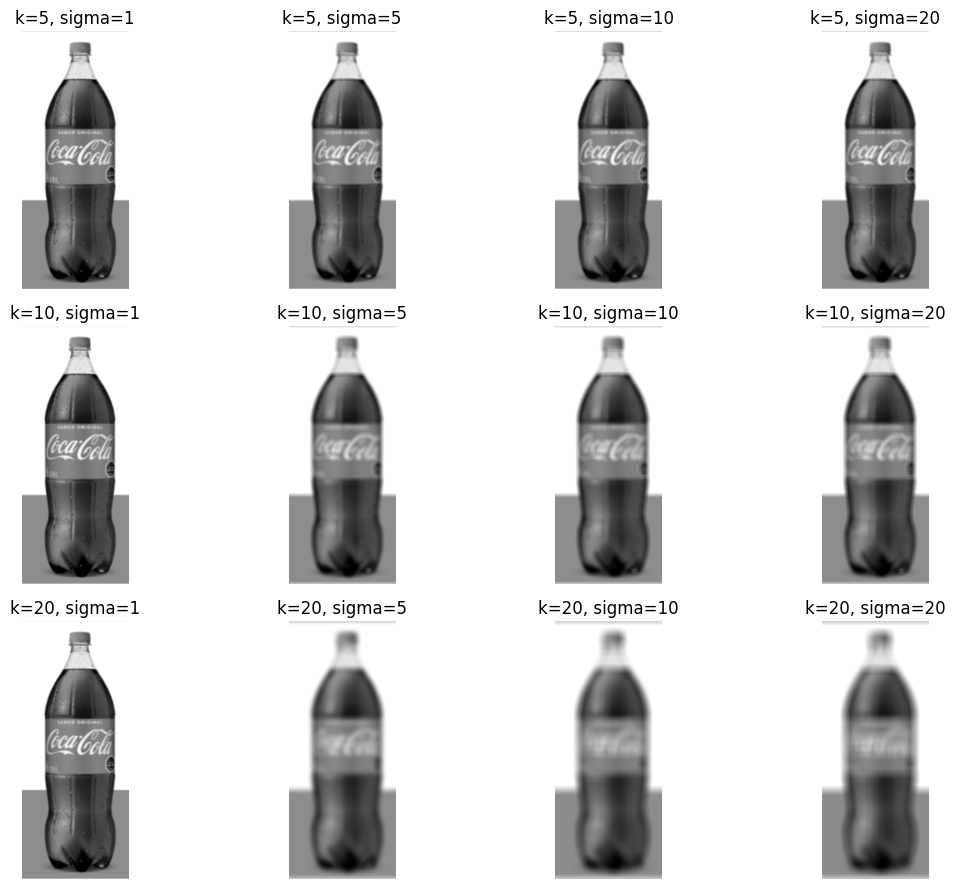

In [9]:
# Grafico en dom espectral
plot_filtered_image(original_img, filter_image_spectral, combinations)


### Observación:

Al ir aumentando los valores del kernel y de sigma, aumenta el efecto del blurriness de la imagen. 
Por lo que podemos observar, es necesario que ambos valores sean elevados para aumentar el efecto, esto es, si uno toma valores altos, por ej el kernel, pero el sigma es bajo, el efecto conseguido es menor. 
Por otro lado se observa que el tamaño del kernel influye más en el efecto blur que el sigma.



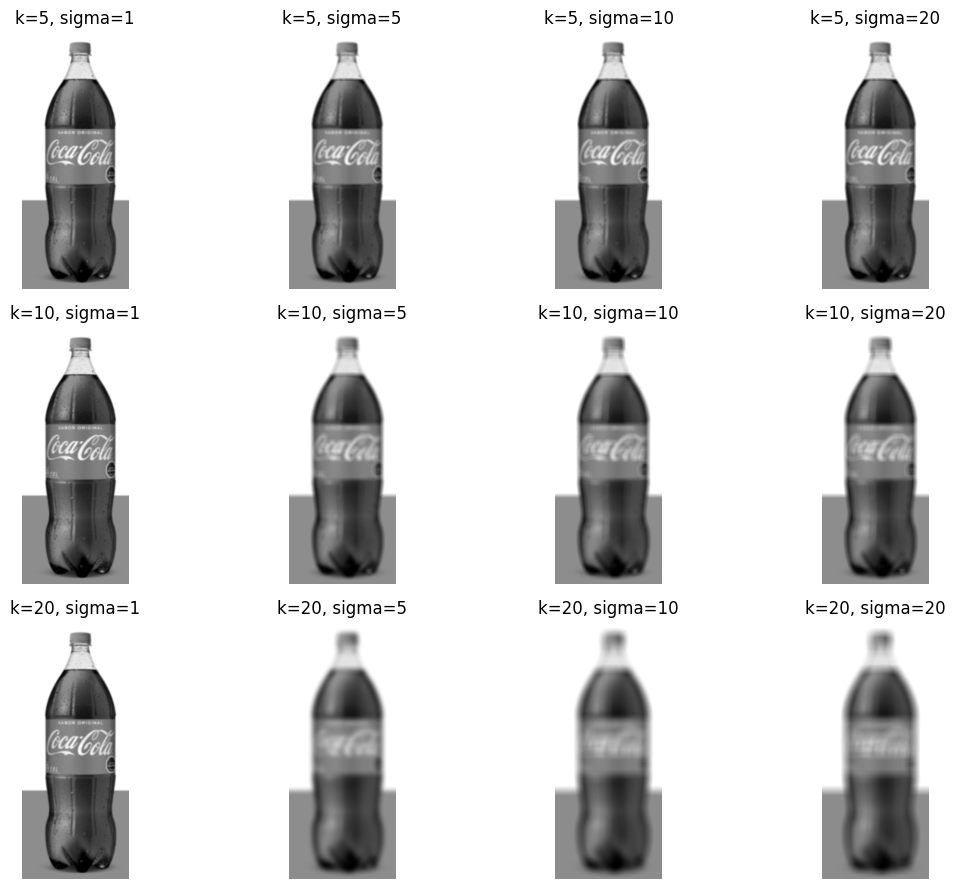

In [10]:
# Grafico convolucional
plot_filtered_image(original_img, filter_image_conv, combinations)

### Observación:

Al realizar el filtrado por convolución de la misma imagen observamos que los resultados son a simple vista iguales. Esto tiene sentido, dado que la convolucion en el dominio del tiempo es equivalente con la multiplicacion en el dominio de la frecuencia cuando se utilizan transformadas de Fourier. 


#### MEDICIÓN DE BLURRINESS DE LAS IMAGENES PROPUESTA EN EL PAPER

## Algorithm for Image Quality Measure (FM)

This algorithm calculates the image quality measure (FM) of an image using the frequency domain. Higher FM values indicate better image quality (less blur).

**Input:**

* Image I of size M×N (numpy array)

**Output:**

* Image quality measure (FM)

**Steps:**

1. **Compute Fourier Transform (F):**
   - Calculate the Fast Fourier Transform (FFT) of the image I.

2. **Find Centered Fourier Transform (Fc):**
   - Shift the origin of F to the center using `fftshift`. This puts the low-frequency components in the center.

3. **Absolute Value (AF):**
   - Calculate the absolute value of the centered Fourier transform (Fc).

4. **Maximum Frequency Component (M):**
   - Find the maximum value in the absolute value array (AF).

5. **Threshold (thres):**
   - Set a threshold value (thres) as a proportion of the maximum value (M) - typically M/1000.

6. **Count High-Frequency Pixels (TH):**
   - Count the number of pixels in AF that are greater than the threshold (thres). These pixels correspond to high-frequency components in the image, which are less affected by blur.

7. **Image Quality Measure (FM):**
   - Calculate the FM using the following equation:
FM = T/(M*N)


In [11]:
from scipy.fft import fft2, fftshift

def freq_focus_measure(img):
    f = fft2(img)
    fc = fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    thres = m/1000
    th = np.sum(af > thres)
    fm = th / (img.shape[0] * img.shape[1])
    return fm

#### TENENGRAD VARIANCE - GRA7

Segun el paper *Analysis of focus measure operators for shape-from-focus*, el operador basado en gradiente GRA7 o Tenengrad variance muestra una muy buena respuesta al ruido.

$$ \phi_{x,y}=\sum_{(ij)\in\Omega(x,y)}(G(ij)-\overline{G})^{2},$$

This operator uses the variance of the image gradient as a focus measure. 


$\phi_{x,y}$: Varianza Tenengrad en el pixel$(x, y)$.

$\sum_{(ij)\in\Omega(x,y)}$: Esta suma itera sobre todos los pixeles vecinos$(i, j)$ dentro de una ventana o todos lso vecinos centrados en $(x, y)$, o sea $\Omega(x, y)$.

$G(ij)$: Valor de intensidad en el  pixel $(i, j)$.

$\overline{G}$: Intensidad promedio dentro de los pixeles vecinos $\Omega(x, y)$.

$(G(ij)-\overline{G})^{2}$: Calcula la diferencia al cuadrado entre la intensidad en $(i, j)$ y la intensidad promedio en los pixeles vecinos. 


Segun el paper citado **Diatom autofocusing in brightfield microscopy: A comparative study (Pacheco et.al, 2000)**: "The method is based on computing the gradient magnitude
of a Sobel operator"


In [102]:
def tenengrad_variance(img):
    img = np.uint8(img)
    sx = cv.Sobel(img, cv.CV_32F, 1, 0, ksize=5)
    sy = cv.Sobel(img, cv.CV_32F, 0, 1, ksize=5)
    tenengrad = cv.magnitude(sx, sy)
    return tenengrad.var()

### MODIFIED LAPLACIAN

$$ \phi(x,y)=\sum_{(i,j)\in\Omega(x,y)}\Delta_{m}I(i,j) $$

En lugar de observar la varianza, observa los valores absolutos de la imagen filtrada

In [103]:
def Lx(img):
  kernelx = np.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]])
  return cv.filter2D(img, cv.CV_32F, np.array(kernelx))

def Ly(img):
  kernely = kernelx = np.array([[0, -1, 0], [0, 2, 0], [0, -1, 0]])
  return cv.filter2D(img, cv.CV_32F, np.array(kernely))

def modified_laplacian(img):
  img = np.uint8(img)
  return (np.abs(Lx(img)) + np.abs(Ly(img))).mean()

### Calculamos las distintas metricas

In [104]:
fm_results_spatial= []
fm_results_spectral = []
fm_results_convolutional = []

tv_results_spatial= []
tv_results_spectral = []
tv_results_convolutional = []

ml_results_spatial= []
ml_results_spectral = []
ml_results_convolutional = []


for k_size, sigma in combinations:
    img_filter_spatial = filter_spatial_domain(original_img,k_size=k_size, sigma=sigma)
    img_filter_spectral = filter_image_spectral(original_img, k_size=k_size, sigma=sigma)
    img_filter_convolutional = filter_image_conv(original_img, k_size=k_size, sigma=sigma)

    # Frequency focus measure
    fm_spatial = freq_focus_measure(img_filter_spatial)
    fm_spectral = freq_focus_measure(img_filter_spectral)
    fm_convolution = freq_focus_measure(img_filter_convolutional)
    
    fm_results_spatial.append((k_size, sigma, fm_spatial))
    fm_results_spectral.append((k_size, sigma, fm_spectral))
    fm_results_convolutional.append((k_size, sigma, fm_convolution))

    # Tenengrad variance
    tv_spatial = tenengrad_variance(img_filter_spatial)
    tv_spectral = tenengrad_variance(img_filter_spectral)
    tv_convolution = tenengrad_variance(img_filter_convolutional)

    tv_results_spatial.append((k_size, sigma, tv_spatial))
    tv_results_spectral.append((k_size, sigma, tv_spectral))
    tv_results_convolutional.append((k_size, sigma, tv_convolution))

    # Modified laplacian
    ml_spatial = modified_laplacian(img_filter_spatial)
    ml_spectral = modified_laplacian(img_filter_spectral)
    ml_convolution = modified_laplacian(img_filter_convolutional)

    ml_results_spatial.append((k_size, sigma, ml_spatial))
    ml_results_spectral.append((k_size, sigma, ml_spectral))
    ml_results_convolutional.append((k_size, sigma, ml_convolution))

In [128]:
print('Frequency focus measure original image:', freq_focus_measure(original_img))
print("Tenengrad variance original image", tenengrad_variance(original_img))
print("Modified Laplacian original image", modified_laplacian(original_img))


Frequency focus measure original image: 0.04068599033816425
Tenengrad variance original image 1985400.9
Modified Laplacian original image 14.027536


### Graficamos

In [123]:
def plot_results_combined(results_spatial, results_spectral, results_convolutional, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 3))
    for results, filter_name in zip([results_spatial, results_spectral, results_convolutional], ['Spatial', 'Spectral', 'Convolutional']):
        k_sizes, sigmas, fms = zip(*results)
        ax.plot(range(len(results)), fms, marker='o', linestyle='-', label=f'{filter_name} Filter')

    ax.set_title(title)
    ax.set_xlabel('Combinations (kernel,sigma)')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(results)))
    ax.set_xticklabels([f'{k_size}, {sigma}' for k_size, sigma in zip(k_sizes, sigmas)], rotation=45)
    ax.grid(True)
    ax.legend()
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()



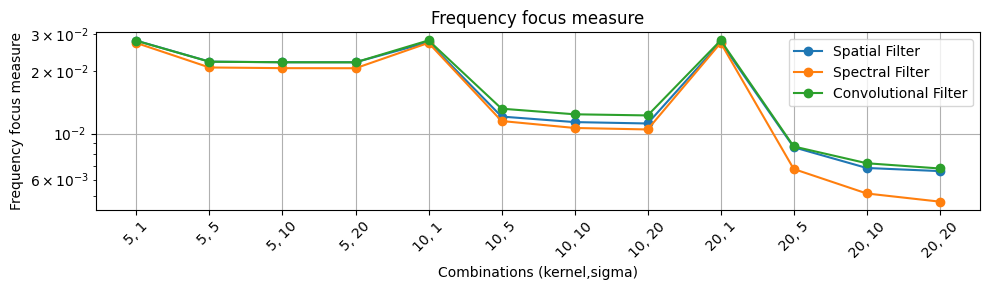

In [129]:
plot_results_combined(fm_results_spatial, fm_results_spectral, fm_results_convolutional, title='Frequency focus measure', ylabel='Frequency focus measure')

### Observación:

A medida que aumentamos el tamaño del kernel y logramos un mayor efecto de blurriness en la imagen, observamos que la calidad de la imagen, de acuerdo con la métrica **Frequency focus measure** empeora para aquellas imagenes filtradas en el dominio espectral cuando aumentamos los valores de kernel, mientras que se mantiene similar para las imagenes filtradas  el dominio espacial y por convolución, siendo apenas un poco mejor la métrica para estas últimas.

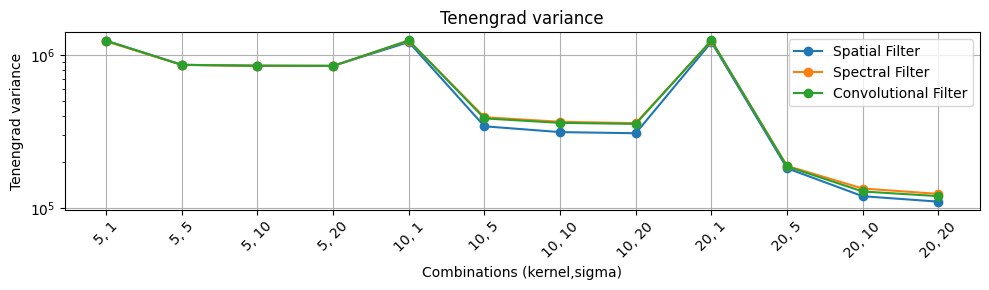

In [125]:
plot_results_combined(tv_results_spatial, tv_results_spectral, tv_results_convolutional, title='Tenengrad variance', ylabel='Tenengrad variance')

### Observación:
Las imagenes filtradas tienen una varianza tenengrad menor que la imagen original, especialmente cuando aumentamos el valor del kernel, lo que nos indica que la imagen esta desenfocada.

De acuerdo con esta métrica, no se observa mayores diferencias entre los tres tipos de filtrado. Esto tiene sentido si consideramos que se calcula en base a las magnitudes de los gradientes de la imagen, que se obtienen utilizando operadores Sobel para calcular las derivadas horizontales y verticales. Los operadores Sobel están diseñados para capturar información de bordes, que es un aspecto fundamental de la estructura de la imagen independientemente del dominio en el que se realice el filtrado. Por lo tanto, la varianza Tenengrad, que se basa en estos gradientes relacionados con los bordes, nos da resultados similares para nuestras imágenes filtradas en los diferentes dominios.

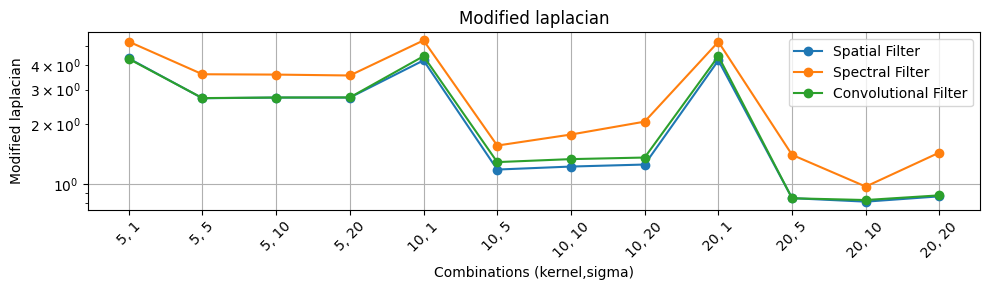

In [126]:
plot_results_combined(ml_results_spatial, ml_results_spectral, ml_results_convolutional, title='Modified laplacian', ylabel='Modified laplacian')

### Observación

Observamos que las imagenes filtradas en el dominio tienen un valor mucho más alto. Esto tiene sentido si tenemos en cuenta que el laplaciano modificado observa los valores absolutos de la imagen filtrada.

Al filtrar en el dominio espectral, estamos trabajando con los componentes de la frecuencia de la imagen. Cuando filtramos en general los componentes de alta frecuencia(que suelen corresponder a los bordes o detalles de la imagen) pueden ser realzados o preservados.

En cambio cuando filtramos una imagen en el dominio espacial o por convolución, lo que estamos haciendo es aplicarle un filtro directamente a los valores de píxeles de la imagen. Esto significa que el filtro afecta a todas las partes de la imagen por igual, independientemente del contenido de frecuencia. Si bien estos filtros son efectivos para suavizar imágenes, es posible que no preserven los detalles de alta frecuencia tan efectivamente como el filtrado en el dominio espectral.

Por lo tanto, al calcular la medida del laplaciano modificado en las imágenes filtradas en el dominio espectral, observamos valores más altos porque el proceso de filtrado puede mejorar o preservar los detalles de alta frecuencia de manera más efectiva, lo que resulta en respuestas de bordes más fuertes en comparación con el filtrado en el dominio espacial.